### **Imports**

In [1]:
import time
start_time = time.time()
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import math
import string
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

### **DataSet** **Upload**

In [2]:
from google.colab import files , drive

#upload for files in google drive
drive.mount('/content/gdrive')
dataset = "/content/gdrive/My Drive/Colab Notebooks/covid_data.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
"""
#alternative for local file upload (file needs to be downloaded locally)
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['covid_data.csv']))
"""

"\n#alternative for local file upload (file needs to be downloaded locally)\nfrom google.colab import files\nuploaded = files.upload()\ndf = pd.read_csv(io.BytesIO(uploaded['covid_data.csv']))\n"

### **DataUpload check**

In [4]:
"""
This try statment will ensure that file loaded is in CSV data format,
otherwise message will be displayed and after any user input
the progam will shutdown.
"""

try:
  df = pd.read_csv(dataset)
  print("CSV reading successful")
except:
  print("File must be CSV")
  print(input())
  exit()

CSV reading successful


In [5]:
df.shape

(67166, 59)

In [6]:
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [7]:
df.nunique()

iso_code                                   192
continent                                    6
location                                   200
date                                       403
total_cases                              34313
new_cases                                 9391
new_cases_smoothed                       17775
total_deaths                             12928
new_deaths                                2305
new_deaths_smoothed                       5143
total_cases_per_million                  48425
new_cases_per_million                    27581
new_cases_smoothed_per_million           31234
total_deaths_per_million                 28379
new_deaths_per_million                    5548
new_deaths_smoothed_per_million           6782
reproduction_rate                          356
icu_patients                              1938
icu_patients_per_million                  3956
hosp_patients                             3696
hosp_patients_per_million                 6291
weekly_icu_ad

In [8]:
df.dtypes.value_counts()

float64    54
object      5
dtype: int64

In [9]:
df.dtypes

iso_code                                  object
continent                                 object
location                                  object
date                                      object
total_cases                              float64
new_cases                                float64
new_cases_smoothed                       float64
total_deaths                             float64
new_deaths                               float64
new_deaths_smoothed                      float64
total_cases_per_million                  float64
new_cases_per_million                    float64
new_cases_smoothed_per_million           float64
total_deaths_per_million                 float64
new_deaths_per_million                   float64
new_deaths_smoothed_per_million          float64
reproduction_rate                        float64
icu_patients                             float64
icu_patients_per_million                 float64
hosp_patients                            float64
hosp_patients_per_mi

### **Data Preprocessing**

In [10]:
df.drop(['new_cases_smoothed','new_deaths_smoothed','new_cases_smoothed_per_million','new_deaths_smoothed_per_million',
         'new_tests_smoothed_per_thousand','new_tests_smoothed', 'new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million'], axis=1, inplace=True)

In [11]:
df = df[df.continent == 'Europe'] #filters europe only entries

In [12]:
df.continent.value_counts() #reduced entries from 67K to 16K

Europe    16203
Name: continent, dtype: int64

In [13]:
"""
Loop to select the countries with the most common entries
INPUT: series of countries with number of entries
OUTPUT: list of the most common countries with the number of entries
"""

i = 0
theMostCommonCountry_List = []
while i < 10:
  part_index = str(df.location.value_counts().index[i])
  theMostCommonCountry_List.append( part_index )
  i = i + 1
print(theMostCommonCountry_List)

['France', 'Switzerland', 'Germany', 'Finland', 'Russia', 'United Kingdom', 'Italy', 'Sweden', 'Estonia', 'Spain']


In [14]:
df = df[df.location.isin(theMostCommonCountry_List)]  #filters entries by list of common countries

In [15]:
df = df.reset_index()   #resets index
df.drop(columns=['index','continent'], inplace=True) #drops old index column and continent becasue it is not needed
df

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,EST,Estonia,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1326539.0,31.033,42.7,19.452,13.491,29481.252,0.5,255.569,4.02,24.5,39.3,NaN,4.69,78.74,0.871
1,EST,Estonia,2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1326539.0,31.033,42.7,19.452,13.491,29481.252,0.5,255.569,4.02,24.5,39.3,NaN,4.69,78.74,0.871
2,EST,Estonia,2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1326539.0,31.033,42.7,19.452,13.491,29481.252,0.5,255.569,4.02,24.5,39.3,NaN,4.69,78.74,0.871
3,EST,Estonia,2020-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1326539.0,31.033,42.7,19.452,13.491,29481.252,0.5,255.569,4.02,24.5,39.3,NaN,4.69,78.74,0.871
4,EST,Estonia,2020-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1326539.0,31.033,42.7,19.452,13.491,29481.252,0.5,255.569,4.02,24.5,39.3,NaN,4.69,78.74,0.871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3742,GBR,United Kingdom,2021-02-02,3863757.0,16906.0,108225.0,1451.0,56915.369,249.035,1594.217,21.374,NaN,3638.0,53.590,31670.0,466.517,NaN,NaN,NaN,NaN,606382.0,71642534.0,1055.336,8.932,0.036,28.1,tests performed,10520433.0,10021471.0,498962.0,376922.0,15.50,14.76,0.73,NaN,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.922
3743,GBR,United Kingdom,2021-02-03,3882972.0,19215.0,109547.0,1322.0,57198.418,283.048,1613.691,19.474,NaN,3625.0,53.398,NaN,NaN,NaN,NaN,NaN,NaN,801949.0,72464146.0,1067.439,11.813,0.034,29.5,tests performed,10992444.0,10490487.0,501957.0,472011.0,16.19,15.45,0.74,NaN,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.922
3744,GBR,United Kingdom,2021-02-04,3903706.0,20734.0,110462.0,915.0,57503.841,305.424,1627.169,13.478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11477040.0,10971047.0,505993.0,484596.0,16.91,16.16,0.75,NaN,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.922
3745,GBR,United Kingdom,2021-02-05,3922910.0,19204.0,111477.0,1015.0,57786.727,282.886,1642.121,14.952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11975267.0,11465210.0,510057.0,498227.0,17.64,16.89,0.75,NaN,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.922


In [16]:
"""
Loop for checking which features are object type
INPUT: pandas series
OUTPUT: list of objects
"""
list_of_objects = []
x=0
while x < len(df.columns):
  if df.dtypes.values[x] == object:
    list_of_objects.append(df.dtypes.index[x])
  x = x + 1
print(list_of_objects)

['iso_code', 'location', 'date', 'tests_units']


In [17]:
df.iso_code = LabelEncoder().fit_transform(df.iso_code)
df.location = LabelEncoder().fit_transform(df.location)
df.date = LabelEncoder().fit_transform(df.date)

In [18]:
df.tests_units.fillna('Not Tested', inplace=True)
df.tests_units.value_counts()

tests performed    2877
Not Tested          605
people tested       265
Name: tests_units, dtype: int64

In [19]:
df.tests_units = df.tests_units.replace(['tests performed', 'people tested'], 'Tested')
df.tests_units.value_counts()

Tested        3142
Not Tested     605
Name: tests_units, dtype: int64

In [20]:
df.tests_units = LabelEncoder().fit_transform(df.tests_units)

In [21]:
df.dtypes

iso_code                                 int64
location                                 int64
date                                     int64
total_cases                            float64
new_cases                              float64
total_deaths                           float64
new_deaths                             float64
total_cases_per_million                float64
new_cases_per_million                  float64
total_deaths_per_million               float64
new_deaths_per_million                 float64
reproduction_rate                      float64
icu_patients                           float64
icu_patients_per_million               float64
hosp_patients                          float64
hosp_patients_per_million              float64
weekly_icu_admissions                  float64
weekly_icu_admissions_per_million      float64
weekly_hosp_admissions                 float64
weekly_hosp_admissions_per_million     float64
new_tests                              float64
total_tests  

In [22]:
df.location.value_counts() #counts amount of entrires 

8    380
2    380
3    377
1    375
9    373
5    373
4    373
7    372
6    372
0    372
Name: location, dtype: int64

In [23]:
correlation_matrix = df.corr().round(2) 
correlation_matrix.shape #checks size of the matrix

(50, 50)

In [24]:
df.isna().sum() #counts NA values

iso_code                                  0
location                                  0
date                                      0
total_cases                              58
new_cases                                58
total_deaths                            383
new_deaths                              383
total_cases_per_million                  58
new_cases_per_million                    58
total_deaths_per_million                383
new_deaths_per_million                  383
reproduction_rate                       521
icu_patients                           1448
icu_patients_per_million               1448
hosp_patients                          1735
hosp_patients_per_million              1735
weekly_icu_admissions                  3562
weekly_icu_admissions_per_million      3562
weekly_hosp_admissions                 3452
weekly_hosp_admissions_per_million     3452
new_tests                              1243
total_tests                            1609
total_tests_per_thousand        

In [25]:
df = df.drop(columns=['handwashing_facilities','weekly_icu_admissions',
                      'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 
                      'weekly_hosp_admissions_per_million', 'icu_patients_per_million',
                      'hosp_patients_per_million', 'total_cases_per_million', 'new_cases_per_million',
                      'total_deaths_per_million', 
                      ]) #drops those columns from the dataset

### **Target Dataset Preprocessing**

In [26]:
print("", df["stringency_index"].max(), " = highest restriction value \n",
      df["stringency_index"].mean(), " = average restriction value \n",
      df["stringency_index"].min(), " = lowest restriction value \n")

 93.52  = highest restriction value 
 54.220298869143704  = average restriction value 
 0.0  = lowest restriction value 



In [27]:


#loop for changing all the values smaller than 53 to 0 
i = 0
while i < len(df): 
  if df.stringency_index[i] < 53.0:
    df.stringency_index  = df.stringency_index.replace(df.stringency_index[i], 0)

  elif math.isnan(df.stringency_index[i]) == True:
    df.stringency_index  = df.stringency_index.replace((df.stringency_index[i]), 0)

  i = i + 1
#loop for changning all the values bigger than 53 to 1
i=0
while i < len(df):
  if df.stringency_index[i] >= 53.0:
    df.stringency_index  = df.stringency_index.replace(df.stringency_index[i], 1)
  i = i + 1


In [28]:
#replace floats with string
df.stringency_index  = df.stringency_index.replace(1.0, "lockdown")
df.stringency_index  = df.stringency_index.replace(0.0, "open")

In [29]:
df.stringency_index.value_counts()

lockdown    2202
open        1545
Name: stringency_index, dtype: int64

In [30]:
df = df.fillna(0)

In [31]:
Y = df.stringency_index
X = df.drop(columns=['stringency_index'])

### **RFE Feature Selection**

In [32]:
#importing algorithm to select best performing features
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier


rfe_selector = RFE(estimator=DecisionTreeClassifier(), n_features_to_select = 10, step = 1)

rfe_transformed = rfe_selector.fit_transform(X, Y)

cols = list(X.columns)

DecisionTreeClassifier().fit(rfe_transformed,Y)

temp = pd.Series(rfe_selector.support_, index=cols) #support changes rfe selector into numpy array

selected_features = temp[temp==True].index

In [33]:
selected_features

Index(['date', 'total_cases', 'total_deaths', 'new_deaths',
       'reproduction_rate', 'icu_patients', 'hosp_patients',
       'population_density', 'aged_65_older', 'male_smokers'],
      dtype='object')

### **Building Model**

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix,classification_report
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [35]:
X = df.filter(items=selected_features)
X

,date,total_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,population_density,aged_65_older,male_smokers
0,8,0.0,0.0,0.0,0.0,0.0,1.0,31.033,19.452,39.3
1,9,0.0,0.0,0.0,0.0,0.0,1.0,31.033,19.452,39.3
2,10,0.0,0.0,0.0,0.0,0.0,1.0,31.033,19.452,39.3
3,11,0.0,0.0,0.0,0.0,0.0,1.0,31.033,19.452,39.3
4,12,0.0,0.0,0.0,0.0,0.0,1.0,31.033,19.452,39.3
...,...,...,...,...,...,...,...,...,...,...
3742,375,3863757.0,108225.0,1451.0,0.0,3638.0,31670.0,272.898,18.517,24.7
3743,376,3882972.0,109547.0,1322.0,0.0,3625.0,0.0,272.898,18.517,24.7
3744,377,3903706.0,110462.0,915.0,0.0,0.0,0.0,272.898,18.517,24.7
3745,378,3922910.0,111477.0,1015.0,0.0,0.0,0.0,272.898,18.517,24.7


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=3)

In [37]:
X_train.shape

(2622, 10)

In [38]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [39]:
performanceList = []
accuracylist = []

In [40]:
#1
gnb = GaussianNB()

model_gnb = gnb.fit(X_train, Y_train)    #fitting the model
y_test_pred = gnb.fit(X_train, Y_train).predict(X_test)    #predicting Gaussian NB the target

print("Training accuracy: {:,.4f}".format(model_gnb.score(X_train, Y_train)))
print("Testing accuracy: {:,.4f}".format(model_gnb.score(X_test, Y_test)))

print("Total points: ", X_test.shape[0], "\nMiss matched points: ", (Y_test != y_test_pred).sum(), "\nAccuracy: {:.4f}".format(accuracy_score(Y_test, y_test_pred)))

performanceList.append(model_gnb)
accuracylist.append(accuracy_score(Y_test, y_test_pred))

Training accuracy: 0.6003
Testing accuracy: 0.6160
Total points:  1125 
Miss matched points:  432 
Accuracy: 0.6160


In [41]:
#2
bnb = BernoulliNB()

model_bnb = bnb.fit(X_train, Y_train)    #fitting Bernoulli NB
y_test_pred = bnb.fit(X_train, Y_train).predict(X_test)    #predicting Bernoulli NB the target

print("Training accuracy: {:,.4f}".format(model_bnb.score(X_train, Y_train)))
print("Testing accuracy: {:,.4f}".format(model_bnb.score(X_test, Y_test)))

print("Total points: ", X_test.shape[0], "\nMiss matched points: ", (Y_test != y_test_pred).sum(), "\nAccuracy: {:.4f}".format(accuracy_score(Y_test, y_test_pred)))

performanceList.append(model_bnb)
accuracylist.append(accuracy_score(Y_test, y_test_pred))

Training accuracy: 0.6617
Testing accuracy: 0.6560
Total points:  1125 
Miss matched points:  387 
Accuracy: 0.6560


In [42]:
#3
logistic = LogisticRegression()

model_log = logistic.fit(X_train, Y_train) #logistic regression is fitted
y_test_pred = model_log.predict(X_test) #predicting Logistic Regression's target

print("Training accuracy: {:,.4f}".format(model_log.score(X_train, Y_train)))
print("Testing accuracy: {:,.4f}".format(model_log.score(X_test, Y_test)))

print("Total points: ", X_test.shape[0], "\nMiss matched points: ", (Y_test != y_test_pred).sum(), "\nAccuracy: {:.4f}".format(accuracy_score(Y_test, y_test_pred)))

performanceList.append(model_log)
accuracylist.append(accuracy_score(Y_test, y_test_pred))

Training accuracy: 0.7384
Testing accuracy: 0.7538
Total points:  1125 
Miss matched points:  277 
Accuracy: 0.7538


In [43]:
#4
svm = SVC(probability=True)

model_SVM = svm.fit(X_train, Y_train)
y_test_pred = model_SVM.predict(X_test)

print("Training accuracy: {:,.4f}".format(model_SVM.score(X_train, Y_train)))
print("Testing accuracy: {:,.4f}".format(model_SVM.score(X_test, Y_test)))

print("Total points: ", X_test.shape[0], "\nMiss matched points: ", (Y_test != y_test_pred).sum(), "\nAccuracy: {:.4f}".format(accuracy_score(Y_test, y_test_pred)))

performanceList.append(model_SVM)
accuracylist.append(accuracy_score(Y_test, y_test_pred))

Training accuracy: 0.9268
Testing accuracy: 0.9191
Total points:  1125 
Miss matched points:  91 
Accuracy: 0.9191


In [44]:
#5
knn = KNeighborsClassifier()

model_knn = knn.fit(X_train, Y_train)
y_test_pred = model_knn.predict(X_test)

print("Training accuracy: {:,.4f}".format(model_knn.score(X_train, Y_train)))
print("Testing accuracy: {:,.4f}".format(model_knn.score(X_test, Y_test)))

print("Total points: ", X_test.shape[0], "\nMiss matched points: ", (Y_test != y_test_pred).sum(), "\nAccuracy: {:.4f}".format(accuracy_score(Y_test, y_test_pred)))

performanceList.append(model_knn)
accuracylist.append(accuracy_score(Y_test, y_test_pred))

Training accuracy: 0.9886
Testing accuracy: 0.9787
Total points:  1125 
Miss matched points:  24 
Accuracy: 0.9787


In [45]:
#6
dTree = DecisionTreeClassifier()

model_dTree = dTree.fit(X_train, Y_train)
y_test_pred = model_dTree.predict(X_test)

print("Training accuracy: {:,.4f}".format(model_dTree.score(X_train, Y_train)))
print("Testing accuracy: {:,.4f}".format(model_dTree.score(X_test, Y_test)))

print("Total points: ", X_test.shape[0], "\nMiss matched points: ", (Y_test != y_test_pred).sum(), "\nAccuracy: {:.4f}".format(accuracy_score(Y_test, y_test_pred)))

performanceList.append(model_dTree)
accuracylist.append(accuracy_score(Y_test, y_test_pred))

Training accuracy: 1.0000
Testing accuracy: 0.9822
Total points:  1125 
Miss matched points:  20 
Accuracy: 0.9822


In [46]:
#7
rForest = RandomForestClassifier()

model_rForest = rForest.fit(X_train, Y_train)
y_test_pred = model_rForest.predict(X_test)

print("Training accuracy: {:,.4f}".format(model_rForest.score(X_train, Y_train)))
print("Testing accuracy: {:,.4f}".format(model_rForest.score(X_test, Y_test)))

print("Total points: ", X_test.shape[0], "\nMiss matched points: ", (Y_test != y_test_pred).sum(), "\nAccuracy: {:.4f}".format(accuracy_score(Y_test, y_test_pred)))

performanceList.append(model_rForest)
accuracylist.append(accuracy_score(Y_test, y_test_pred))

Training accuracy: 1.0000
Testing accuracy: 0.9884
Total points:  1125 
Miss matched points:  13 
Accuracy: 0.9884


In [47]:
#8
adaB = AdaBoostClassifier()

model_adaB = adaB.fit(X_train, Y_train)
y_test_pred = model_adaB.predict(X_test)

print("Training accuracy: {:,.4f}".format(model_adaB.score(X_train, Y_train)))
print("Testing accuracy: {:,.4f}".format(model_adaB.score(X_test, Y_test)))

print("Total points: ", X_test.shape[0], "\nMiss matched points: ", (Y_test != y_test_pred).sum(), "\nAccuracy: {:.4f}".format(accuracy_score(Y_test, y_test_pred)))

performanceList.append(model_adaB)
accuracylist.append(accuracy_score(Y_test, y_test_pred))

Training accuracy: 0.9561
Testing accuracy: 0.9342
Total points:  1125 
Miss matched points:  74 
Accuracy: 0.9342


In [48]:
i=0 
print("{0:<24} {1:>8} {2:>12}".format("Algorithm","Float Value", "Percentage"),"\n")
while i < len(performanceList):
  print("{0:<24} {1:>8} {2:>12}".format(type(performanceList[i]).__name__, accuracylist[i].round(4), str((accuracylist[i]*100).round(2))+"%")) 
  i=i+1

Algorithm                Float Value   Percentage 

GaussianNB                  0.616        61.6%
BernoulliNB                 0.656        65.6%
LogisticRegression         0.7538       75.38%
SVC                        0.9191       91.91%
KNeighborsClassifier       0.9787       97.87%
DecisionTreeClassifier     0.9822       98.22%
RandomForestClassifier     0.9884       98.84%
AdaBoostClassifier         0.9342       93.42%


### **Cross Validation**

In [49]:
"""
Loop for performing cross validation on every model.
INPUT: List of models 
OUTPUT: List of models with mean accuracy score after cross validation
"""
lista={}
i=0 
print("{0:<24} {1:>8} {2:>16} {3:>14}".format("Algorithm","CV value","Original value","Difference"),"\n")
while i < len(performanceList):
  clf = cross_val_score(performanceList[i], X, Y, cv=10, scoring='accuracy')
  clf_rounded = clf.mean().round(4)
  al = accuracylist[i].round(4)
  if (al - clf_rounded > 0):
    difference = "-"+str((al - clf_rounded).round(4))
  elif (al - clf_rounded == 0):
    difference = str((al - clf_rounded).round(4))
  else :
    difference = "+"+str((al - clf_rounded).round(4))
  print("{0:<24} {1:>8} {2:>12} {3:>16}".format(type(performanceList[i]).__name__, clf_rounded, al, difference)) 

  lista[type(performanceList[i]).__name__] = clf_rounded
  i=i+1

Algorithm                CV value   Original value     Difference 

GaussianNB                 0.5796        0.616          -0.0364
BernoulliNB                 0.651        0.656           -0.005
LogisticRegression         0.6458       0.7538           -0.108
SVC                        0.7177       0.9191          -0.2014
KNeighborsClassifier       0.6221       0.9787          -0.3566
DecisionTreeClassifier     0.5819       0.9822          -0.4003
RandomForestClassifier     0.6361       0.9884          -0.3523
AdaBoostClassifier         0.6403       0.9342          -0.2939


In [50]:
sorted_list = dict(sorted(lista.items(),key=lambda item:item[1]))

best_performing_algo = list(sorted_list.keys())[-1]

print(best_performing_algo)

SVC


### **Hyperparamater** **Tuning** 

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
ada_grid = {'n_estimators': [10, 30, 50, 70, 90, 100],
               'algorithm': ['SAMME','SAMME.R'],
            'random_state': [1,2,3,4,5]}

dTree_grid= {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [10, 30, 50, 70, 90, 100, None],
              'min_samples_split': [2, 5, 10],
              'splitter':['best','random'],
              'citerion': ['gini','entropy'],
              'random_state': [1,2,3,4,5]}

knn_grid={'n_neighbors': [3,5,11,19],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan'],
            'algorithm':['ball_tree','kd_tree','brute']}

rfc_grid={'n_estimators': [10, 30, 50, 70, 90, 100],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [10, 30, 50, 70, 90, 100, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False],
                'random_state': [1,2,3,4,5]}

gnb_grid={}

svc_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale','auto'],
          'gamma': ['scale','auto'],
          'C':[0.1,1,10,100],
          'random_state': [1,2,3,4,5]}

log_grid={'random_state': [1,2,3,4,5]}

bnb_grid={}

In [53]:
if (best_performing_algo == "RandomForestClassifier"):
  model = RandomForestClassifier()
  grid = rfc_grid
  model_TH = model_rForest

elif (best_performing_algo == "KNeighborsClassifier"):
  model = KNeighborsClassifier()
  grid = knn_grid
  model_TH = model_knn

elif (best_performing_algo == "DecisionTreeClassifier"):
  model = DecisionTreeClassifier()
  grid = dTree_grid
  model_TH = model_dTree

elif (best_performing_algo == "AdaBoostClassifier"):
  model = AdaBoostClassifier()
  grid = ada_grid
  model_TH = model_adaB

elif (best_performing_algo == "GaussianNB"):
  model = GaussianNB()
  grid = gnb_grid
  model_TH = model_gnb

elif (best_performing_algo == "SVC"):
  model = SVC()
  grid = svc_grid
  model_TH = model_SVM

elif (best_performing_algo == "LogisticRegression"):
  model = LogisticRegression()
  grid = log_grid
  model_TH = model_log

elif (best_performing_algo == "BernoulliNB"):
  model = BernoulliNB()
  grid = bnb_grid
  model_TH = model_bnb

In [54]:
"""grid = GridSearchCV(model, grid, verbose=1, cv=10,n_jobs=-1)
grid_results = grid.fit(X_train,Y_train)

print("Best estimator: ",grid_results.best_estimator_)
print("Best parameters: ",grid_results.best_params_)

print("Best score:", grid_results.best_score_)
"""

'grid = GridSearchCV(model, grid, verbose=1, cv=10,n_jobs=-1)\ngrid_results = grid.fit(X_train,Y_train)\n\nprint("Best estimator: ",grid_results.best_estimator_)\nprint("Best parameters: ",grid_results.best_params_)\n\nprint("Best score:", grid_results.best_score_)\n'

### **Threshold Manipulation**

In [ ]:
Y_test = Y_test.replace(['lockdown'],1)
Y_test = Y_test.replace(['open'],0)

Y_test = Y_test.to_numpy()

In [68]:
defaultThreshold = 0.5
newThreshold = 0.6
X_test = pd.DataFrame(X_test) #reforming X testing set

y_test_pred = model_TH.predict(X_test)
y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred = y_test_pred.replace(['lockdown'],1)
y_test_pred = y_test_pred.replace(['open'],0)

y_train_pred = model_TH.predict(X_train)
new_y_test_pred = np.where(model_TH.predict_proba(X_test)[:,1]>newThreshold,0,1)

model_TH.predict_proba(X_test)
#visual aid to see how the values are distribued with threshold
print("y_test\n",pd.DataFrame(Y_test)[0].value_counts()) 
print("\ny_test_pred\n",pd.DataFrame(y_test_pred)[0].value_counts())
print("\nnew_y_test_pred\n",pd.DataFrame(new_y_test_pred)[0].value_counts())

new_threshold_report = classification_report(Y_test, new_y_test_pred, target_names=['open','lockdown'])

print(new_threshold_report)

y_test
 1    651
0    474
Name: 0, dtype: int64

y_test_pred
 1    686
0    439
Name: 0, dtype: int64

new_y_test_pred
 1    696
0    429
Name: 0, dtype: int64


### **Confusion and evaluation Matrix**

In [57]:
Y_train = Y_train.replace(['open'],0)
Y_train = Y_train.replace(['lockdown'],1)

model = model.fit(X_train,Y_train)

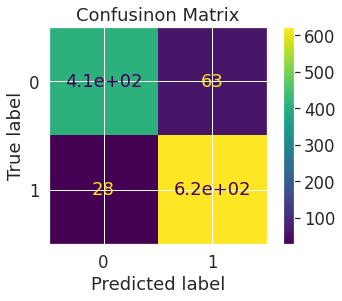

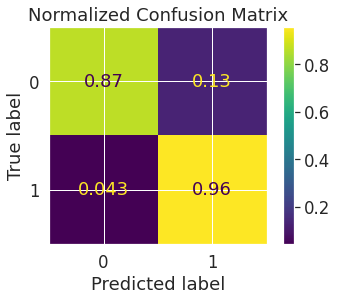

In [58]:
sns.set(font_scale=1.5)

cfm = confusion_matrix(Y_test,y_test_pred)
cfm

#Raw CM
disp = plot_confusion_matrix(model, X_test, Y_test)#plots the matrix
disp.ax_.set_title("Confusinon Matrix") #sets the title
plt.show()

print()

#Normalised CM
disp = plot_confusion_matrix(model, X_test, Y_test,
                             normalize='true') #plots the matrix
disp.ax_.set_title("Normalized Confusion Matrix") #sets the title
plt.show()

In [59]:
rep_cp = classification_report(Y_test, y_test_pred, target_names=['open','lockdown']) #generates Classification Report
print(rep_cp)

              precision    recall  f1-score   support

        open       0.94      0.87      0.90       474
    lockdown       0.91      0.96      0.93       651

    accuracy                           0.92      1125
   macro avg       0.92      0.91      0.92      1125
weighted avg       0.92      0.92      0.92      1125



In [60]:
from sklearn.metrics import precision_score, recall_score

pd.DataFrame(data=[[accuracy_score(Y_test, y_test_pred),
                    precision_score(Y_test, y_test_pred),
                    recall_score(Y_test, y_test_pred)]],
            columns=["Accuracy","Precision", "Recall"],
            index=['Score'])

,Accuracy,Precision,Recall
Score,0.919111,0.908163,0.956989


In [61]:
print("%s seconds" % (time.time() - start_time))

40.57803130149841 seconds
